# Decide threshold

The goal of this notebook is to define a threshold to determine if a sample if PAO1 or not (likewise, if a sample is PA14 or not). We used known labels from SRA to do this. Specifically, we examined the distribution of PAO1 samples (grey) vs non-PAO1 samples (blue). We define the threshold to be one that separated between the two distributions. We use this threshold in [1_create_compendia.ipynb](1_create_compendia.ipynb) to partition gene expression data into PAO1 and PA14 compendia.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
from textwrap import fill
import matplotlib.pyplot as plt
import utils

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Raw (TPM) expression data files
pao1_expression_filename = "../qc_filtering/qc-out/pao1_aligned_compendium_p2_filtered_counts_norm.csv" 
pa14_expression_filename = "../qc_filtering/qc-out/pa14_aligned_compendium_p2_filtered_counts_norm.csv"

# File containing table to map sample id to strain name
sample_to_strain_filename = "Run_Table_Strain_Bool_GD.csv"

In [3]:
# Load expression data
# Matrices will be sample x gene after taking the transpose
pao1_expression = pd.read_csv(pao1_expression_filename, index_col=0, header=0).T
pa14_expression = pd.read_csv(pa14_expression_filename, index_col=0, header=0).T

In [4]:
# Load metadata
# Set index to experiment id, which is what we will use to map to expression data
sample_to_strain_table_full = pd.read_csv(sample_to_strain_filename, index_col=2)

## Format expression data

Format index to only include experiment id. This will be used to map to expression data and SRA labels later

In [5]:
# Format expression data indices so that values can be mapped to `sample_to_strain_table`
pao1_index_processed = pao1_expression.index.str.split(".").str[0]
pa14_index_processed = pa14_expression.index.str.split(".").str[0]

print(
    f"No. of samples processed using PAO1 reference after filtering: {pao1_expression.shape}"
)
print(
    f"No. of samples processed using PA14 reference after filtering: {pa14_expression.shape}"
)
pao1_expression.index = pao1_index_processed
pa14_expression.index = pa14_index_processed

No. of samples processed using PAO1 reference after filtering: (2588, 5563)
No. of samples processed using PA14 reference after filtering: (2588, 5891)


In [6]:
pao1_expression.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541571,5589.915138,897.177641,1373.180223,1801.831763,139.560966,505.908503,480.986902,662.914591,677.867551,77.256964,...,0.0,97.194244,468.526102,12.460801,87.225604,74.764803,77.256964,2275.342185,249.216012,0.000000
ERX541572,6297.494504,831.965260,1747.273260,1807.221548,190.079936,416.713706,320.211585,491.283528,663.817624,45.326754,...,0.0,80.418435,485.434914,10.235073,70.183361,46.788907,59.948288,2209.313721,198.852856,0.000000
ERX541573,4948.395849,892.785667,1982.509348,1750.122490,350.549666,362.365947,372.869308,464.773715,615.759526,42.013443,...,0.0,114.224049,781.187458,19.693801,153.611651,43.326363,106.346528,1473.096350,101.094848,0.000000
ERX541574,4633.161907,778.582016,2242.316207,1923.696490,313.828444,325.806628,438.401566,438.401566,510.270675,79.056020,...,0.0,153.320766,565.370326,21.560733,86.242931,38.330192,64.682198,2129.721269,79.056020,2.395637
ERX541575,4228.807727,868.906226,2124.210932,1775.079310,317.749004,286.366386,274.597904,572.732772,733.568687,56.880994,...,0.0,135.337539,672.764866,15.691309,194.179947,21.575550,117.684816,1637.780358,60.803822,0.000000


In [7]:
pa14_expression.head()

,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
ERX541571,211.451625,56.208660,0.000000,2.676603,10.706411,10.706411,18.736220,72.268277,66.915071,5.353206,...,42.825646,141.859951,3522.409344,182.008993,21.412823,2.676603,1025.138890,390.784015,152.566362,0.0
ERX541572,221.780416,51.647494,6.076176,15.190439,21.266615,9.114264,12.152352,78.990285,82.028373,3.038088,...,60.761758,179.247186,2953.021435,221.780416,27.342791,15.190439,1193.968543,568.122437,118.485428,0.0
ERX541573,168.134943,44.835985,18.214619,23.819117,8.406747,18.214619,5.604498,64.451728,57.446106,8.406747,...,56.044981,208.767554,1820.060757,68.655102,4.203374,12.610121,1548.242600,619.297040,63.050604,0.0
ERX541574,203.805778,13.505202,6.138728,14.732948,4.910983,17.188439,8.594220,47.882080,58.931791,7.366474,...,67.526011,227.132945,2248.002282,77.347976,6.138728,12.277456,1706.566451,898.709814,165.745663,0.0
ERX541575,193.980790,46.386711,8.433947,29.518816,8.433947,12.650921,4.216974,44.278224,42.169737,6.325461,...,40.061250,250.909936,1575.039679,65.363092,4.216974,10.542434,1313.587310,710.560070,145.485593,0.0


## Format SRA annotations

In [8]:
# Since experiments have multiple runs there are duplicated experiment ids in the index
# We will need to remove these so that the count calculations are accurate
sample_to_strain_table_full_processed = sample_to_strain_table_full[
    ~sample_to_strain_table_full.index.duplicated(keep="first")
]

assert (
    len(sample_to_strain_table_full.index.unique())
    == sample_to_strain_table_full_processed.shape[0]
)

In [9]:
# Aggregate boolean labels into a single strain label
aggregated_label = []
for exp_id in list(sample_to_strain_table_full_processed.index):
    if sample_to_strain_table_full_processed.loc[exp_id, "PAO1"].all() == True:
        aggregated_label.append("PAO1")
    elif sample_to_strain_table_full_processed.loc[exp_id, "PA14"].all() == True:
        aggregated_label.append("PA14")
    elif sample_to_strain_table_full_processed.loc[exp_id, "PAK"].all() == True:
        aggregated_label.append("PAK")
    elif (
        sample_to_strain_table_full_processed.loc[exp_id, "ClinicalIsolate"].all()
        == True
    ):
        aggregated_label.append("Clinical Isolate")
    else:
        aggregated_label.append("NA")

sample_to_strain_table_full_processed["Strain type"] = aggregated_label

sample_to_strain_table = sample_to_strain_table_full_processed["Strain type"].to_frame()

sample_to_strain_table.head()

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Strain type
Experiment,
SRX5057740,NA
SRX5057739,NA
SRX5057910,NA
SRX5057909,NA
SRX3573046,PAO1


## Label samples with SRA annotations

In [10]:
# Label samples with SRA annotations
# pao1_expression_label = pao1_expression_binned.join(
#    sample_to_strain_table, how='left')
pao1_expression_label = pao1_expression.merge(
    sample_to_strain_table, left_index=True, right_index=True
)
pa14_expression_label = pa14_expression.merge(
    sample_to_strain_table, left_index=True, right_index=True
)
print(pao1_expression_label.shape)
pao1_expression_label.head()

(2588, 5564)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1,Strain type
ERX541571,5589.915138,897.177641,1373.180223,1801.831763,139.560966,505.908503,480.986902,662.914591,677.867551,77.256964,...,97.194244,468.526102,12.460801,87.225604,74.764803,77.256964,2275.342185,249.216012,0.000000,NA
ERX541572,6297.494504,831.965260,1747.273260,1807.221548,190.079936,416.713706,320.211585,491.283528,663.817624,45.326754,...,80.418435,485.434914,10.235073,70.183361,46.788907,59.948288,2209.313721,198.852856,0.000000,NA
ERX541573,4948.395849,892.785667,1982.509348,1750.122490,350.549666,362.365947,372.869308,464.773715,615.759526,42.013443,...,114.224049,781.187458,19.693801,153.611651,43.326363,106.346528,1473.096350,101.094848,0.000000,NA
ERX541574,4633.161907,778.582016,2242.316207,1923.696490,313.828444,325.806628,438.401566,438.401566,510.270675,79.056020,...,153.320766,565.370326,21.560733,86.242931,38.330192,64.682198,2129.721269,79.056020,2.395637,NA
ERX541575,4228.807727,868.906226,2124.210932,1775.079310,317.749004,286.366386,274.597904,572.732772,733.568687,56.880994,...,135.337539,672.764866,15.691309,194.179947,21.575550,117.684816,1637.780358,60.803822,0.000000,NA


In [11]:
print(pa14_expression_label.shape)
pa14_expression_label.head()

(2588, 5892)


,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845,Strain type
ERX541571,211.451625,56.208660,0.000000,2.676603,10.706411,10.706411,18.736220,72.268277,66.915071,5.353206,...,141.859951,3522.409344,182.008993,21.412823,2.676603,1025.138890,390.784015,152.566362,0.0,NA
ERX541572,221.780416,51.647494,6.076176,15.190439,21.266615,9.114264,12.152352,78.990285,82.028373,3.038088,...,179.247186,2953.021435,221.780416,27.342791,15.190439,1193.968543,568.122437,118.485428,0.0,NA
ERX541573,168.134943,44.835985,18.214619,23.819117,8.406747,18.214619,5.604498,64.451728,57.446106,8.406747,...,208.767554,1820.060757,68.655102,4.203374,12.610121,1548.242600,619.297040,63.050604,0.0,NA
ERX541574,203.805778,13.505202,6.138728,14.732948,4.910983,17.188439,8.594220,47.882080,58.931791,7.366474,...,227.132945,2248.002282,77.347976,6.138728,12.277456,1706.566451,898.709814,165.745663,0.0,NA
ERX541575,193.980790,46.386711,8.433947,29.518816,8.433947,12.650921,4.216974,44.278224,42.169737,6.325461,...,250.909936,1575.039679,65.363092,4.216974,10.542434,1313.587310,710.560070,145.485593,0.0,NA


## Get accessory gene expression

In [12]:
pao1_annot_filename = "PAO1_ID_2_PA14_ID_PAO1ref.csv" 
pa14_annot_filename = "PA14_ID_2_PAO1_ID_PA14ref.csv"

core_acc_dict = utils.get_my_core_acc_genes(
    pao1_annot_filename, pa14_annot_filename, pao1_expression, pa14_expression
)

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5361
Number of PAO1-specific genes: 202
Number of PA14-specific genes: 530


In [13]:
pao1_acc = core_acc_dict["acc_pao1"]
pa14_acc = core_acc_dict["acc_pa14"]

In [14]:
# Create accessory df
# accessory gene ids | median accessory expression | strain label

# PAO1
pao1_acc_expression = pao1_expression_label[pao1_acc]
pao1_acc_expression["median_acc_expression"] = pao1_acc_expression.median(axis=1)

# PA14
pa14_acc_expression = pa14_expression_label[pa14_acc]
pa14_acc_expression["median_acc_expression"] = pa14_acc_expression.median(axis=1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [15]:
# Add back labels
pao1_acc_expression["Strain type"] = pao1_expression_label["Strain type"]
pa14_acc_expression["Strain type"] = pa14_expression_label["Strain type"]

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
pao1_acc_expression.head()

,PA4105,PA1381,PA2073,PA2733,PA2732,PA2101,PA2074,PA5253,PA5570,PA3157,...,PA2333,PA0643,PA1150,PA2771,PA3504,PA2106,PA3154,PA0715,median_acc_expression,Strain type
ERX541571,4.984320,59.811843,19.937281,304.043534,1565.076552,32.398081,12.460801,503.416343,1477.850948,2988.099978,...,59.811843,274.137613,1298.415420,528.337944,42.366722,104.670725,4341.342921,4154.430912,89.717764,NA
ERX541572,7.310767,38.015987,17.545840,400.630020,1745.811107,38.015987,14.621534,675.514850,1415.364449,2858.509811,...,137.442415,226.633770,1238.443892,388.932793,54.099674,127.207342,3539.873275,3889.327927,87.729201,NA
ERX541573,10.503361,24.945482,27.571322,242.890218,2151.876040,31.510082,13.129201,905.914867,2284.480970,3412.279334,...,122.101569,254.706499,2115.114278,372.869308,70.897685,106.346528,1954.938026,5556.277854,91.247947,NA
ERX541574,7.186911,33.538918,21.560733,318.619717,2541.770829,103.012390,9.582548,512.666312,1954.839770,4745.756844,...,304.245896,297.058985,3188.592812,368.928094,93.429842,172.485862,2759.773793,5948.366605,104.210208,NA
ERX541575,15.691309,25.498377,25.498377,239.292460,2702.827944,70.610890,7.845654,957.169838,3357.940088,3622.730924,...,56.880994,213.794083,2149.709308,394.244134,58.842408,70.610890,2114.403864,6623.693736,82.379371,NA


In [17]:
pa14_acc_expression.head()

,PA14_46620,PA14_69510,PA14_03163,PA14_59370,PA14_59390,PA14_59770,PA14_35700,PA14_59940,PA14_28460,PA14_19600,...,PA14_27650,PA14_21260,PA14_60140,PA14_46510,PA14_03400,PA14_23430,PA14_30900,PA14_28760,median_acc_expression,Strain type
ERX541571,5.353206,0.000000,0.000000,5.353206,0.0,0.000000,5.353206,8.029809,29.442631,5.353206,...,0.000000,74.944880,0.000000,5.353206,0.0,0.0,2.676603,74.944880,0.000000,NA
ERX541572,0.000000,3.038088,3.038088,0.000000,0.0,3.038088,0.000000,6.076176,60.761758,24.304703,...,12.152352,1534.234387,3.038088,0.000000,0.0,0.0,3.038088,63.799846,3.038088,NA
ERX541573,2.802249,1.401125,1.401125,0.000000,0.0,0.000000,0.000000,5.604498,47.638234,35.028113,...,0.000000,2194.161005,0.000000,1.401125,0.0,0.0,0.000000,112.089962,1.401125,NA
ERX541574,3.683237,1.227746,0.000000,0.000000,0.0,0.000000,1.227746,6.138728,55.248554,34.376878,...,0.000000,2611.414994,1.227746,0.000000,0.0,0.0,2.455491,110.497108,1.227746,NA
ERX541575,4.216974,0.000000,0.000000,0.000000,0.0,2.108487,0.000000,6.325461,52.712171,14.759408,...,0.000000,2182.283893,0.000000,0.000000,0.0,0.0,4.216974,99.098882,2.108487,NA


In [18]:
# Merge PAO1 and PA14 accessory dataframes
pao1_pa14_acc_expression = pao1_acc_expression.merge(
    pa14_acc_expression,
    left_index=True,
    right_index=True,
    suffixes=["_pao1", "_pa14"],
)

pao1_pa14_acc_expression.head()

,PA4105,PA1381,PA2073,PA2733,PA2732,PA2101,PA2074,PA5253,PA5570,PA3157,...,PA14_27650,PA14_21260,PA14_60140,PA14_46510,PA14_03400,PA14_23430,PA14_30900,PA14_28760,median_acc_expression_pa14,Strain type_pa14
ERX541571,4.984320,59.811843,19.937281,304.043534,1565.076552,32.398081,12.460801,503.416343,1477.850948,2988.099978,...,0.000000,74.944880,0.000000,5.353206,0.0,0.0,2.676603,74.944880,0.000000,NA
ERX541572,7.310767,38.015987,17.545840,400.630020,1745.811107,38.015987,14.621534,675.514850,1415.364449,2858.509811,...,12.152352,1534.234387,3.038088,0.000000,0.0,0.0,3.038088,63.799846,3.038088,NA
ERX541573,10.503361,24.945482,27.571322,242.890218,2151.876040,31.510082,13.129201,905.914867,2284.480970,3412.279334,...,0.000000,2194.161005,0.000000,1.401125,0.0,0.0,0.000000,112.089962,1.401125,NA
ERX541574,7.186911,33.538918,21.560733,318.619717,2541.770829,103.012390,9.582548,512.666312,1954.839770,4745.756844,...,0.000000,2611.414994,1.227746,0.000000,0.0,0.0,2.455491,110.497108,1.227746,NA
ERX541575,15.691309,25.498377,25.498377,239.292460,2702.827944,70.610890,7.845654,957.169838,3357.940088,3622.730924,...,0.000000,2182.283893,0.000000,0.000000,0.0,0.0,4.216974,99.098882,2.108487,NA


## Plot distribution

In [19]:
# Get PAO1 samples that are labeled PAO1 and non-PAO1
pao1_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pao1"] == "PAO1",
    "median_acc_expression_pao1",
]

non_pao1_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pao1"] != "PAO1",
    "median_acc_expression_pao1",
]

In [20]:
pao1_threshold = 25

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


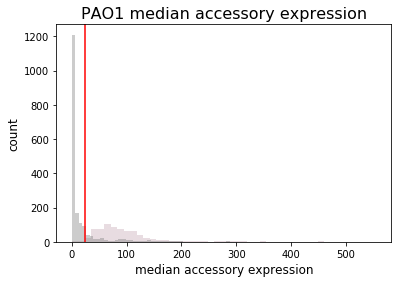

In [21]:
f = sns.distplot(pao1_sra, color="#C6A9B5", kde=False)
f = sns.distplot(non_pao1_sra, color="grey", kde=False)
plt.axvline(pao1_threshold, 0, 100, color="red")
plt.title("PAO1 median accessory expression", family="sans-serif", size=16)
plt.xlabel("median accessory expression", family="sans-serif", size=12)
plt.ylabel("count", family="sans-serif", size=12)
f.figure.savefig("pao1_threshold_dist.svg", format="svg", dpi=300)

In [22]:
# Get PA14 samples that are labeled PA14 and non-PA14
pa14_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pa14"] == "PA14",
    "median_acc_expression_pa14",
]

non_pa14_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pa14"] != "PA14",
    "median_acc_expression_pa14",
]

In [23]:
pa14_threshold = 25

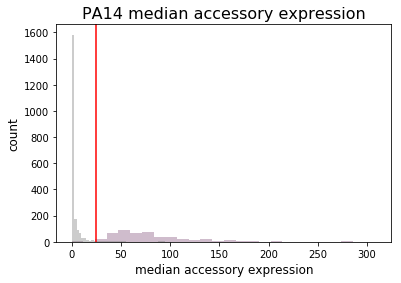

In [24]:
g = sns.distplot(pa14_sra, color="#895881", kde=False)
g = sns.distplot(non_pa14_sra, color="grey", kde=False)
plt.axvline(pa14_threshold, 0, 100, color="red")
plt.title("PA14 median accessory expression", family="sans-serif", size=16)
plt.xlabel("median accessory expression", family="sans-serif", size=12)
plt.ylabel("count", family="sans-serif", size=12)
g.figure.savefig("pa14_threshold_dist.svg", format="svg", dpi=300)

**Takeaway:**
Looks like using a threshold of 25 TPM separates between SRA-annotated PAO1 samples vs non-PAO1 samples. Similarly for PA14. This is the threshold we'll use to bin samples into PAO1 vs PA14 compendia.